# Figure 7: Classifying TFs into Neg. Regs. vs. Rewirers

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot
from isoform_pairwise_metrics import load_ref_vs_alt_isoforms_table

from data_loading import (load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## functions

In [5]:
def calculate_tau(df):
    array = df.values
    
    ## will return NaN as tau for every row that has any NaNs
    array_max = np.max(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nonan_taus = np.sum(tmp, axis=1) / (array.shape[1])
    
    ## will ignore NaNs and compute on the rest of the values
    array_max = np.nanmax(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nan_taus = np.nansum(tmp, axis=1) / np.count_nonzero(~np.isnan(array), axis=1)
    
    
    return nonan_taus, nan_taus, array_max

In [6]:
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

In [7]:
dn_pal = {"ref": sns.color_palette("Set2")[0],
       "similar": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray",
          "combination": sns.color_palette("Set2")[5]}

## variables

In [8]:
joung_orf_f = "../../data/external/joung_files/Joung_ORF_lib.txt"
joung_data_f = "../../data/external/joung_files/Joung_ORF_scores.txt"
joung_cells_f = "../../data/external/joung_files/Figure3B_celltype_mapping.csv"

joung_down_map_batch_f = "../../data/external/joung_files/subsample_mapping_batch.txt"
joung_down_map_TF_f = "../../data/external/joung_files/subsample_mapping_TF.txt"
joung_down_map_louvain_f = "../../data/external/joung_files/subsample_mapping_louvain.txt"

## 1. import data

In [9]:
pairs = load_ref_vs_alt_isoforms_table()

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
pairs = pairs[pairs["clone_acc_alt"] != "RORC|1/6|05F11"]

pairs['ref_iso'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['alt_iso'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [10]:
joung_orf = pd.read_table(joung_orf_f)
joung_orf["Name"] = joung_orf["Name"].str.strip()

joung_data = pd.read_table(joung_data_f)
joung_data["Name"] = joung_data["TF ORF"].str.split("-", expand=True)[0].str.strip()

joung_cells = pd.read_table(joung_cells_f, sep=",")

joung_down_map_batch = pd.read_table(joung_down_map_batch_f, index_col=0)
print(len(joung_down_map_batch))
joung_down_map_TF = pd.read_table(joung_down_map_TF_f, index_col=0)
print(len(joung_down_map_TF))
joung_down_map_louvain = pd.read_table(joung_down_map_louvain_f, index_col=0)
print(len(joung_down_map_louvain))

joung_down_map = joung_down_map_batch.join(joung_down_map_TF).join(joung_down_map_louvain)
print(len(joung_down_map))

671453
671453
671453
671453


In [11]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [12]:
metadata_gtex_dummy = pd.read_table("../../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

In [13]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


## 2. categorize based on assay data

### M1H

In [14]:
def m1h_cat(row):
    
    # ref is activator
    if row.activation_ref >= 1:
        if row.activation_fold_change_log2 <= -1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "activation loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "rewire"
            else:
                return "similar"

        else:
            return "NA"
    
    # ref is repressor
    elif row.activation_ref <= -1:
        if row.activation_fold_change_log2 >= 1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "repression loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "rewire"
            else:
                return "similar"
        else:
            return "NA"
        
    # no ref data so can't make conclusions
    elif pd.isnull(row.activation_ref):
        return "NA"
    
    # ref is middling so can be GoF
    else:
        if row.activation_fold_change_log2 >= 1:
            return "activation GoF"
        elif row.activation_fold_change_log2 <= -1:
            return "repression GoF"
        
        # if both isoforms are middling, consider similar
        elif not pd.isnull(row.activation_fold_change_log2):
            return "similar"
        
        else:
            return "NA"
        
pairs["m1h_cat"] = pairs.apply(m1h_cat, axis=1)
pairs.m1h_cat.value_counts()

similar            194
NA                 119
rewire              61
activation loss     39
repression GoF      16
activation GoF       9
repression loss      8
Name: m1h_cat, dtype: int64

### Y1H

In [15]:
def y1h_cat(row):
    if row.n_positive_PDI_ref_filtered > 0:
        if row.n_positive_PDI_alt_filtered == 0:
            return "PDI loss"
        elif row.n_shared_PDI == row.n_PDI_successfully_tested_in_ref_and_alt:
            return "no PDI change"
        elif pd.isnull(row.n_positive_PDI_alt_filtered):
            return "NA"
        else:
            return "PDI rewire"
    elif row.n_positive_PDI_ref_filtered == 0:
        if row.n_positive_PDI_alt_filtered > 0:
            return "PDI gain"
        else:
            return "NA"
    else:
        return "NA"
    
pairs["y1h_cat"] = pairs.apply(y1h_cat, axis=1)
pairs.y1h_cat.value_counts()

NA               374
PDI loss          28
PDI rewire        27
PDI gain           9
no PDI change      8
Name: y1h_cat, dtype: int64

### Y2H

In [16]:
def y2h_cat(row):
    if row.dimer_ppi == "loses all" or row.tf_cofactor_ppi == "loses all" or row.tf_signalling_ppi == "loses all":
        n = []
        if row.dimer_ppi == "loses all":
            n.append("dimer")
        if row.tf_cofactor_ppi == "loses all":
            n.append("cofactor")
        if row.tf_signalling_ppi == "loses all":
            n.append("signalling")
        s = ",".join(n)
        s = "PPI loss: %s" % s
        return s
    
    elif row.n_positive_PPI_ref > 0 and row.n_positive_PPI_alt == 0:
        return "PPI loss: all"
    
    elif row.dimer_ppi == "retains all" and row.tf_cofactor_ppi == "retains all" and row.tf_signalling_ppi == "retains all":
        if row.other_than_dimer_ppi == "retains all":
            return "no PPI change (all PPIs)"
        else:
            return "no PPI change (important PPIs)"
    
    elif pd.isnull(row.dimer_ppi) and pd.isnull(row.tf_cofactor_ppi) and pd.isnull(row.tf_signalling_ppi) and pd.isnull(row.other_than_dimer_ppi) and pd.isnull(row.tf_tf_ppi):
        return "NA"
    
    else:
        
        # all PPIs retained but some above categories null so missed in if statements
        if row.PPI_jaccard == 1:
            return "no PPI change (all PPIs)"
        else:
            return "PPI rewire"
    
pairs["y2h_cat"] = pairs.apply(y2h_cat, axis=1)
pairs.y2h_cat.value_counts()

NA                                296
PPI loss: all                      53
PPI rewire                         43
no PPI change (all PPIs)           31
PPI loss: cofactor,signalling       7
PPI loss: signalling                5
PPI loss: cofactor                  5
PPI loss: dimer                     3
no PPI change (important PPIs)      3
Name: y2h_cat, dtype: int64

## 3. categorize negative regulators
include any whose DBD loss is >= 10%?

In [17]:
def dn_cat(row):
    
    # if activity loss
    if "loss" in row.m1h_cat:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = ["activ"]
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= 10:
                    n.append("DBD loss")
                s = ",".join(n)
                s = "DN (%s)" % s
                return s
    
    # otherwise, if no evidence of m1h activity
    elif row.activation_alt <= 1 and row.activation_alt >= -1:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= 50:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                    
                else:
                    
                    # if m1h category is similar, and y1h/y2h are also no change, consider similar
                    if row.m1h_cat == "similar":
                        if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                            s = "similar"
                        elif row.y1h_cat == "no PDI change" and row.y2h_cat == "NA":
                            s = "similar"
                        elif row.y1h_cat == "NA" and "no PPI change" in row.y2h_cat:
                            s = "similar"
                        else:
                            s = "rewire"
                    else:
                        s = "rewire"
                
                return s
    
    # otherwise, if no m1h data
    elif pd.isnull(row.activation_alt):
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "NA"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            elif row.y1h_cat != "NA" and row.y2h_cat != "NA":
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= 10:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                else:
                    
                    # if both y1h and y2h are similar, consider similar
                    if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    else:
                        s = "rewire"
                
                return s
            
            else:
                return "NA"
            
    # otherwise, if evidence of m1h functionality
    else:
        if row.y1h_cat == "NA" and row.y2h_cat == "NA":
            return "NA"
        else:
            n = []
            if "loss" in row.y1h_cat:
                n.append("PDIs")
            if "loss" in row.y2h_cat:
                n.append("PPIs")
            if row.dbd_pct_lost >= 10:
                n.append("DBD loss")

            if len(n) > 0:
                s = ",".join(n)
                s = "DN (%s)" % s
            else:
                
                # if m1h category is similar, and y1h/y2h are also no change, consider similar
                if row.m1h_cat == "similar":
                    if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    elif row.y1h_cat == "no PDI change" and row.y2h_cat == "NA":
                        s = "similar"
                    elif row.y1h_cat == "NA" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    else:
                        s = "rewire"
                else:
                    s = "rewire"

            return s
            
pairs["dn_cat"] = pairs.apply(dn_cat, axis=1)
pairs.dn_cat.value_counts()

NA                               273
rewire                            58
DN (PPIs)                         32
DN (PPIs,DBD loss)                19
similar                           16
DN (DBD loss)                     11
DN (PDIs,DBD loss)                 9
DN (PDIs)                          5
DN (activ,PPIs)                    4
DN (activ)                         4
DN (PDIs,PPIs,DBD loss)            3
DN (activ,DBD loss)                2
DN (activ,PDIs,DBD loss)           2
DN (PDIs,PPIs)                     2
DN (activ,PPIs,DBD loss)           2
DN (activ,PDIs,PPIs)               1
DN (activ,PDIs)                    1
DN (activ,PDIs,PPIs,DBD loss)      1
likely nf                          1
Name: dn_cat, dtype: int64

In [18]:
# double check that rewirers aren't all the same across axes

In [19]:
to_plot = pairs[pairs["dn_cat"].isin(["rewire", "similar"])][["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                              "PPI_jaccard", "PDI_jaccard", "dbd_pct_lost",
                                              "activation_fold_change_log2", "dn_cat"]]

# make cols that are easier to visualize on plot
to_plot["fc_abs_activ"] = 2**-np.abs(to_plot["activation_fold_change_log2"])
to_plot["1m_dbd_pct"] = (100-to_plot["dbd_pct_lost"])/100

In [20]:
isos = to_plot.copy()
isos = isos.sort_values(by="dn_cat")
isos = isos.reset_index().reset_index()

theoretical_iso = {"level_0": [isos.level_0.max()+1], "index": [0], "gene_symbol": ["theoretical"],
                   "clone_acc_ref": ["theoretical"], "clone_acc_alt": ["theoretical"],
                   "PPI_jaccard": [1.0], "PDI_jaccard": [1.0], "dbd_pct_lost": [0.0],
                   "activation_fold_change_log2": [np.log2(1)], "fc_abs_activ": [1.0],
                   "1m_dbd_pct": [1.0], "dn_cat": ["theoretical"]}

isos = isos.append(pd.DataFrame.from_dict(theoretical_iso))
isos

,level_0,index,gene_symbol,clone_acc_ref,clone_acc_alt,PPI_jaccard,PDI_jaccard,dbd_pct_lost,activation_fold_change_log2,dn_cat,fc_abs_activ,1m_dbd_pct
0,0,0,ZBTB18,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,0.750,0.000000,0.000000,0.503414,rewire,0.705435,1.000000
1,1,212,FLI1,FLI1|1/4|05A01,FLI1|3/4|05A02,NaN,1.000000,0.000000,1.006852,rewire,0.497631,1.000000
2,2,439,ZIC3,ZIC3|2/3|12F04,ZIC3|3/3|09C04,NaN,0.705882,1.197605,-1.470214,rewire,0.360929,0.988024
3,3,250,RFX4,RFX4|1/3|10C04,RFX4|2/3|10D02,0.625,NaN,0.000000,-0.660592,rewire,0.632619,1.000000
4,4,253,RARG,RARG|1/2|08F10,RARG|2/2|08C10,0.000,0.666667,0.000000,0.436118,rewire,0.739121,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,350,ZNF397,ZNF397|2/5|11C06,ZNF397|4/5|08G07,1.000,NaN,NaN,-0.563765,similar,0.676534,NaN
71,71,349,ZNF397,ZNF397|2/5|11C06,ZNF397|3/5|08H07,1.000,NaN,NaN,-0.073502,similar,0.950328,NaN
72,72,339,ZNF18,ZNF18|2/3|07H02,ZNF18|3/3|07D01,1.000,1.000000,0.000000,-0.136085,similar,0.909985,1.000000
73,73,291,SMAD3,SMAD3|1/4|06A07,SMAD3|2/4|06G07,1.000,NaN,0.000000,0.246502,similar,0.842938,1.000000


In [21]:
columns_to_plot = ["level_0", "PPI_jaccard", "PDI_jaccard", "fc_abs_activ", "1m_dbd_pct"]
column_titles = ["", "PPI\n(jaccard)", "PDI\n(jaccard)",
                 "activ.\n(% of ref.)", "DBD\n(% of ref.)"]

# separate into similar v rewires
isos_sim = isos[isos["dn_cat"].isin(["similar", "theoretical"])]
isos_rw = isos[isos["dn_cat"].isin(["rewire"])]

colors = sns.color_palette("husl", n_colors=len(isos_rw))

### similar first

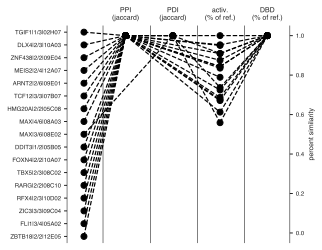

In [22]:
# Creating the figure and axes (subplots) aligned in a single row without shared y-axis
gs_kw = dict(width_ratios=[0.75, 1, 1, 1, 1])
fig, axs = plt.subplots(1, 5, sharey=False, gridspec_kw=gs_kw)
fig.set_size_inches(w=4, h=4)
df = isos_sim

# Adjusting the space between subplots for better alignment of lines
fig.subplots_adjust(wspace=0.05)

# zorder of axis labels
plt.rcParams["axes.axisbelow"] = False

# Re-plotting each column in a separate subplot
for i, col in enumerate(columns_to_plot):
    axs[i].clear()  # Clear previous axes to avoid duplication
    axs[i].set_title(column_titles[i])  # Setting the title of the subplot to the column name
    axs[i].set_xticks([])  # Hide x-axis labels

    # Setting different limits for y-axis based on column data
    axs[i].set_ylim(np.nanmin(df[col]) - 0.1, np.nanmax(df[col]) + 0.1)
    
    j = 0
    black_js = []
    for name, cat in zip(df['clone_acc_alt'], df['dn_cat']):
        if name == "theoretical":
            color = "black"
            black_js.append(j)
        elif cat == "similar":
            color = "black"
            black_js.append(j)
        else:
            color = colors[j]
        
        # Mark the value with a dot
        axs[i].plot(0, df[col].iloc[j], color=color, marker='o', 
                    markersize=6)
        j += 1
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    
    if i == 0:
        axs[i].spines['right'].set_visible(False)
    elif i == 4:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel("percent similarity")
    else:
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_tick_params(labelleft=False)
        axs[i].set_yticks([])

# Remove previous lines
fig.lines = []

# set axis limits
tickpos = list(df["level_0"])
axs[0].set_ylim((tickpos[0]-0.5), (tickpos[-1]+0.5))
axs[1].set_ylim((-0.05, 1.05))
axs[2].set_ylim((-0.05, 1.05))
axs[3].set_ylim((-0.05, 1.05))
axs[4].set_ylim((-0.05, 1.05))


# Data preparation for plotting
data_lines = []
for _, row in df.iterrows():
    data_lines.append([row[columns_to_plot[0]], row[columns_to_plot[1]], 
                       row[columns_to_plot[2]], row[columns_to_plot[3]],
                       row[columns_to_plot[4]]])

# Re-connecting dots across subplots with lines
for j, data_line in enumerate(data_lines):
    if j in black_js:
        color = "black"
    else:
        color = colors[j]
        
    skip_flag = False
    
    # Adding lines between subplots; adjusting coordinates for subplot borders
    for k in range(len(axs)-1):
        # We use figure coordinates to draw lines between subplots
        transFigure = fig.transFigure.inverted()
        
        
        if not skip_flag:
            pt1_k = k
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
        
        # if we prev skipped due to na, keep the same pt1 and use current pt2
        else:
            pt1_k = k-1
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
            
        if np.isnan(pt2):
            #print("skip flag true")
            skip_flag = True
            continue
        else:
            skip_flag = False
        
        #print("pt1: %s | pt2: %s | ax1: %s | ax2: %s" % (pt1, pt2, pt1_k, pt2_k))
        
        # Get coordinates of the points in figure coordinate system
        coord1 = transFigure.transform(axs[pt1_k].transData.transform([0, pt1]))
        coord2 = transFigure.transform(axs[pt2_k].transData.transform([0, pt2]))

        # Calculate the space adjustment based on the subplot spacing
        #space_adjustment = 0.015 + 0.23 * k

        # Adding space adjustment to x-coordinate for accurate alignment
        line = plt.Line2D((coord1[0], coord2[0]), 
                          (coord1[1], coord2[1]), 
                          transform=fig.transFigure, color=color, linestyle="dashed")
        fig.add_artist(line)
        


# relabel ticks
ticklabels = list(isos["clone_acc_alt"])
axs[0].set_yticks(tickpos)
_ = axs[0].set_yticklabels(ticklabels)

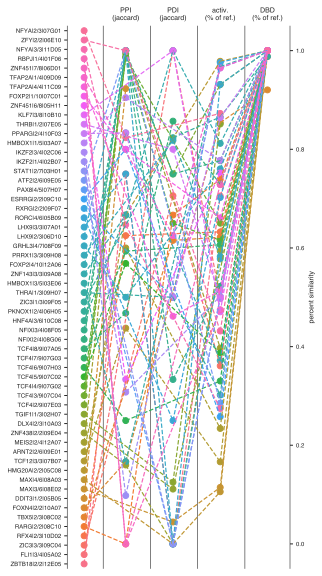

In [23]:
# Creating the figure and axes (subplots) aligned in a single row without shared y-axis
gs_kw = dict(width_ratios=[0.75, 1, 1, 1, 1])
fig, axs = plt.subplots(1, 5, sharey=False, gridspec_kw=gs_kw)
fig.set_size_inches(w=4, h=10)
df = isos_rw

# Adjusting the space between subplots for better alignment of lines
fig.subplots_adjust(wspace=0.05)

# zorder of axis labels
plt.rcParams["axes.axisbelow"] = False

# Re-plotting each column in a separate subplot
for i, col in enumerate(columns_to_plot):
    axs[i].clear()  # Clear previous axes to avoid duplication
    axs[i].set_title(column_titles[i])  # Setting the title of the subplot to the column name
    axs[i].set_xticks([])  # Hide x-axis labels

    # Setting different limits for y-axis based on column data
    axs[i].set_ylim(np.nanmin(df[col]) - 0.1, np.nanmax(df[col]) + 0.1)
    
    j = 0
    black_js = []
    for name, cat in zip(df['clone_acc_alt'], df['dn_cat']):
        if name == "theoretical":
            color = "black"
            black_js.append(j)
        elif cat == "similar":
            color = "black"
            black_js.append(j)
        else:
            color = colors[j]
        
        # Mark the value with a dot
        axs[i].plot(0, df[col].iloc[j], color=color, marker='o', 
                    markersize=6)
        j += 1
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    
    if i == 0:
        axs[i].spines['right'].set_visible(False)
    elif i == 4:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel("percent similarity")
    else:
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_tick_params(labelleft=False)
        axs[i].set_yticks([])

# Remove previous lines
fig.lines = []

# set axis limits
tickpos = list(df["level_0"])
axs[0].set_ylim((tickpos[0]-0.5), (tickpos[-1]+0.5))
axs[1].set_ylim((-0.05, 1.05))
axs[2].set_ylim((-0.05, 1.05))
axs[3].set_ylim((-0.05, 1.05))
axs[4].set_ylim((-0.05, 1.05))


# Data preparation for plotting
data_lines = []
for _, row in df.iterrows():
    data_lines.append([row[columns_to_plot[0]], row[columns_to_plot[1]], 
                       row[columns_to_plot[2]], row[columns_to_plot[3]],
                       row[columns_to_plot[4]]])

# Re-connecting dots across subplots with lines
for j, data_line in enumerate(data_lines):
    if j in black_js:
        color = "black"
    else:
        color = colors[j]
        
    skip_flag = False
    
    # Adding lines between subplots; adjusting coordinates for subplot borders
    for k in range(len(axs)-1):
        # We use figure coordinates to draw lines between subplots
        transFigure = fig.transFigure.inverted()
        
        
        if not skip_flag:
            pt1_k = k
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
        
        # if we prev skipped due to na, keep the same pt1 and use current pt2
        else:
            pt1_k = k-1
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
            
        if np.isnan(pt2):
            #print("skip flag true")
            skip_flag = True
            continue
        else:
            skip_flag = False
        
        #print("pt1: %s | pt2: %s | ax1: %s | ax2: %s" % (pt1, pt2, pt1_k, pt2_k))
        
        # Get coordinates of the points in figure coordinate system
        coord1 = transFigure.transform(axs[pt1_k].transData.transform([0, pt1]))
        coord2 = transFigure.transform(axs[pt2_k].transData.transform([0, pt2]))

        # Calculate the space adjustment based on the subplot spacing
        #space_adjustment = 0.015 + 0.23 * k

        # Adding space adjustment to x-coordinate for accurate alignment
        line = plt.Line2D((coord1[0], coord2[0]), 
                          (coord1[1], coord2[1]), 
                          transform=fig.transFigure, color=color, linestyle="dashed")
        fig.add_artist(line)
        


# relabel ticks
ticklabels = list(isos["clone_acc_alt"])
axs[0].set_yticks(tickpos)
_ = axs[0].set_yticklabels(ticklabels)

## 4. summary plots of DN categorization

In [24]:
pairs["dn_short"] = pairs["dn_cat"].str.split(" ", expand=True)[0]
pairs.dn_short.value_counts()

NA         273
DN          98
rewire      58
similar     16
likely       1
Name: dn_short, dtype: int64

In [25]:
def mech_bool(row, mech_col):
    if "DN" in row.dn_cat:
        if mech_col in row.dn_cat:
            return True
        else:
            return False
    else:
        return np.nan
    
pairs["dn_ppi"] = pairs.apply(mech_bool, mech_col="PPIs", axis=1)
pairs["dn_pdi"] = pairs.apply(mech_bool, mech_col="PDIs", axis=1)
pairs["dn_activ"] = pairs.apply(mech_bool, mech_col="activ", axis=1)
pairs["dn_dbd"] = pairs.apply(mech_bool, mech_col="DBD loss", axis=1)
pairs[pairs["dn_short"] == "DN"].sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,alt_iso,m1h_cat,y1h_cat,y2h_cat,dn_cat,dn_short,dn_ppi,dn_pdi,dn_activ,dn_dbd
53,STAT1,ENSG00000115415,STAT,True,STAT1|1/7|01B05,STAT1|5/7|03C01,ENST00000361099|ENST00000409465,ENST00000540176,False,False,...,STAT1-5,NA,PDI gain,NA,DN (DBD loss),DN,False,False,False,True
344,NFATC1,ENSG00000131196,Rel,True,NFATC1|1/2|10D12,NFATC1|2/2|09D10,ENST00000591814,ENST00000587635,False,False,...,NFATC1-2,similar,PDI loss,NA,"DN (PDIs,DBD loss)",DN,False,True,False,True
121,ZNF451,ENSG00000112200,C2H2 ZF,False,ZNF451|2/8|06C02,ZNF451|3/8|06A03,ENST00000370708,NaN,False,True,...,ZNF451-3,similar,NA,PPI loss: all,DN (PPIs),DN,True,False,False,False
292,SMAD3,ENSG00000166949,SMAD,True,SMAD3|1/4|06A07,SMAD3|3/4|06B08,ENST00000327367,ENST00000439724,False,False,...,SMAD3-3,similar,NA,PPI loss: all,"DN (PPIs,DBD loss)",DN,True,False,False,True
435,PATZ1,ENSG00000100105,C2H2 ZF; AT hook,False,PATZ1|1/4|02C02,PATZ1|3/4|02A04,ENST00000351933,ENST00000405309,False,False,...,PATZ1-3,rewire,NA,PPI loss: cofactor,"DN (PPIs,DBD loss)",DN,True,False,False,True


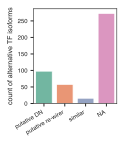

In [26]:
fig = plt.figure(figsize=(1.5, 1.75))

ax = sns.countplot(data=pairs, x="dn_short", palette=sns.color_palette("Set2"),
                   order=["DN", "rewire", "similar", "NA"])
ax.set_xticklabels(["putative DN", "putative re-wirer", "similar", "NA"], ha="right", va="top", rotation=30)
ax.set_xlabel("")
ax.set_ylabel("count of alternative TF isoforms")

fig.savefig("../../figures/fig7/DN_countplot.pdf", dpi="figure", bbox_inches="tight")

In [27]:
from upsetplot import plot

98


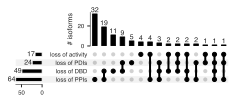

In [28]:
ppis = list(set(list(pairs[pairs["dn_ppi"] == True]["clone_acc_alt"])))
pdis = list(set(list(pairs[pairs["dn_pdi"] == True]["clone_acc_alt"])))
activ = list(set(list(pairs[pairs["dn_activ"] == True]["clone_acc_alt"])))
dbd = list(set(list(pairs[pairs["dn_dbd"] == True]["clone_acc_alt"])))

contents = {"loss of PPIs": ppis, "loss of PDIs": pdis, "loss of activity": activ, "loss of DBD": dbd}
contents = upsetplot.from_contents(contents)

all_dn = set(ppis).union(set(pdis)).union(set(activ)).union(set(dbd))
print(len(all_dn))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_negreg_upset.pdf", dpi="figure", bbox_inches="tight")

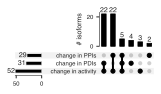

In [29]:
rw = pairs[pairs["dn_cat"] == "rewire"]
ppis = list(set(list(rw[rw["y2h_cat"] == "PPI rewire"]["clone_acc_alt"])))
pdis = list(set(list(rw[rw["y1h_cat"].str.contains("PDI")]["clone_acc_alt"])))
activ = list(set(list(rw[rw["m1h_cat"] != "NA"]["clone_acc_alt"])))

contents = {"change in PPIs": ppis, "change in PDIs": pdis, "change in activity": activ}
contents = upsetplot.from_contents(contents)

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_rewire_upset.pdf", dpi="figure", bbox_inches="tight")

364


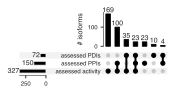

In [30]:
ppis = list(set(list(pairs[pairs["y2h_cat"] != "NA"]["clone_acc_alt"])))
pdis = list(set(list(pairs[pairs["y1h_cat"] != "NA"]["clone_acc_alt"])))
activ = list(set(list(pairs[pairs["m1h_cat"] != "NA"]["clone_acc_alt"])))

contents = {"assessed PPIs": ppis, "assessed PDIs": pdis, "assessed activity": activ}
contents = upsetplot.from_contents(contents)

all_as = set(ppis).union(set(pdis)).union(set(activ))
print(len(all_as))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_pairs_assessed_upset.pdf", dpi="figure", bbox_inches="tight")

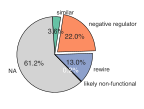

In [31]:
y = np.array([len(pairs[pairs["dn_short"] == "rewire"]), 
              len(pairs[pairs["dn_short"] == "DN"]),
              len(pairs[pairs["dn_short"] == "similar"]),
              len(pairs[pairs["dn_short"] == "NA"]), 
              len(pairs[pairs["dn_short"] == "likely"])])
labels = ["rewire", "negative regulator", "similar", "NA", "likely non-functional"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[0],
          "lightgray", "darkgray"]

fig = plt.figure(figsize=(1.75, 1.75))
ws, ls, ns = plt.pie(y, labels=labels, colors=colors, autopct='%1.1f%%', startangle=-45, explode=(0, 0.1, 0, 0, 0))
for w in ws:
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
ns[4].set_color("white")

fig.savefig("../../figures/fig7/dn_pie.incl_NA.pdf", dpi="figure", bbox_inches="tight")

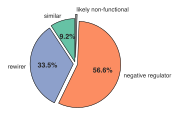

In [32]:
ys = np.array([len(pairs[pairs["dn_short"] == "similar"]),
               len(pairs[pairs["dn_short"] == "rewire"]), 
               len(pairs[pairs["dn_short"] == "DN"]),
               len(pairs[pairs["dn_short"] == "likely"])])
labels = ["similar", "rewirer", "negative regulator", "likely non-functional"]
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], "darkgray"]

fig, ax = plt.subplots(figsize=(2.0, 2.0), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, 
                    explode=(0.05, 0.05, 0.05, 0.15))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")
ns[3].set_text("")

fig.savefig("../../figures/fig7/dn_pie.no_NA.pdf", dpi="figure", bbox_inches="tight")

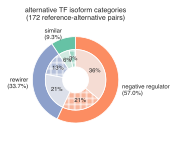

In [33]:
outer_ys = np.array([len(pairs[(pairs["dn_short"] == "similar")]),
                     len(pairs[(pairs["dn_short"] == "rewire")]), 
                     len(pairs[(pairs["dn_short"] == "DN")])])
outer_labels = ["similar\n(%s%%)" % round((outer_ys[0]/np.sum(outer_ys)*100),1),
                "rewirer\n(%s%%)" % round((outer_ys[1]/np.sum(outer_ys)*100),1), 
                "negative regulator\n(%s%%)" % round((outer_ys[2]/np.sum(outer_ys)*100),1)]
outer_colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1]]

inner_ys = np.array([len(pairs[(pairs["dn_short"] == "similar") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "similar") & (~pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "rewire") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "rewire") & (~pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "DN") & (pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "DN") & (~pairs["is_alt_novel_isoform"])])])
inner_colors = [sns.light_palette(sns.color_palette("Set2")[0])[3], 
                sns.light_palette(sns.color_palette("Set2")[0])[1], 
                sns.light_palette(sns.color_palette("Set2")[2])[3], 
                sns.light_palette(sns.color_palette("Set2")[2])[1], 
                sns.light_palette(sns.color_palette("Set2")[1])[3], 
                sns.light_palette(sns.color_palette("Set2")[1])[1]]
hatches = ['++', '', '++', '', '++', '']


fig, ax = plt.subplots(figsize=(2.0, 2.0), subplot_kw=dict(aspect="equal"))

o_ws, o_ls = ax.pie(outer_ys, colors=outer_colors, labels=outer_labels,
                    startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))
i_ws, i_ls, i_ns = ax.pie(inner_ys, colors=inner_colors, autopct='%1.0f%%', 
                          startangle=90, radius=0.7, 
                          wedgeprops=dict(width=0.4, edgecolor='w'),
                          textprops={'size': 'smaller'}, pctdistance=0.7)

for i, w in enumerate(i_ws):
    w.set(hatch=hatches[i])
    
ax.set_title("alternative TF isoform categories\n(%s reference-alternative pairs)" % (np.sum(outer_ys)))

fig.savefig("../../figures/fig7/dn_pie.novel_nested.pdf", dpi="figure", bbox_inches="tight")

In [34]:
# create df for stacked bar chart
delta_pdis = pairs[~pairs["y1h_cat"].isin(["NA", "no PDI change"])]
pdis_vc = pd.DataFrame(delta_pdis.dn_short.value_counts()).reset_index()

delta_ppis = pairs[~pairs["y2h_cat"].isin(["NA", "no PPI change (important PPIs)", "no PPI change (all PPIs)"])]
ppis_vc = pd.DataFrame(delta_ppis.dn_short.value_counts()).reset_index()

delta_activ = pairs[~pairs["m1h_cat"].isin(["NA", "similar"])]
activ_vc = pd.DataFrame(delta_activ.dn_short.value_counts()).reset_index()

mrg = pdis_vc.merge(ppis_vc, on="index", how="outer").merge(activ_vc, on="index", how="outer")
mrg.fillna(0, inplace=True)
mrg.columns = ["index", "PDIs", "PPIs", "activity"]

to_plot = pd.melt(mrg, id_vars="index")
to_plot.sample(5)

,index,variable,value
11,likely,activity,1
3,likely,PDIs,1
1,rewire,PDIs,28
6,NA,PPIs,12
2,NA,PDIs,5


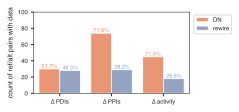

In [35]:
pal = {"likely": "darkgray", "NA": "lightgray", "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1]}

fig = plt.figure(figsize=(2.8, 1.5))

ax = sns.barplot(data=to_plot[~to_plot["index"].isin(["likely", "NA", "similar"])], 
                 x="variable", hue="index", y="value", palette=pal)
plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("")
ax.set_xticklabels(["∆ PDIs", "∆ PPIs", "∆ activity"])
ax.set_ylabel("count of ref/alt pairs with data")
ax.set_ylim((0, 100))

sub = to_plot[~to_plot["index"].isin(["likely", "NA", "similar"])]
for i, cat in enumerate(["PDIs", "PPIs", "activity"]):
    cat_sub = sub[(sub["variable"] == cat)]
    n_dn = cat_sub[cat_sub["index"] == "DN"].value.iloc[0]
    n_rw = cat_sub[cat_sub["index"] == "rewire"].value.iloc[0]
    p_dn = round(n_dn/np.sum(cat_sub["value"])*100, 1)
    p_rw = round(n_rw/np.sum(cat_sub["value"])*100, 1)
    
    ax.text(i-0.2, n_dn, "%s%%" % p_dn, va="bottom", ha="center", color=pal["DN"], fontsize=5.5)
    ax.text(i+0.2, n_rw, "%s%%" % p_rw, va="bottom", ha="center", color=pal["rewire"], fontsize=5.5)
    
# NUMERS LOOK OFF HERE -- CHECK

In [36]:
# make stacked barchart situation
tmp = pairs[pairs["dn_short"] == "DN"]
dn_pdi_change = len(tmp[tmp["dn_pdi"] == True])
dn_ppi_change = len(tmp[tmp["dn_ppi"] == True])
dn_activ_change = len(tmp[tmp["dn_activ"] == True])
dn_dbd_change = len(tmp[tmp["dn_dbd"] == True])
tot_dn = dn_pdi_change + dn_ppi_change + dn_activ_change + dn_dbd_change

tmp = pairs[pairs["dn_short"] == "rewire"]
rw_pdi_change = len(tmp[~tmp["y1h_cat"].isin(["NA", "no PDI change"])])
rw_ppi_change = len(tmp[~tmp["y2h_cat"].isin(["NA", "no PPI change (important PPIs)"])])
rw_activ_change = len(tmp[tmp["m1h_cat"] != "NA"])
rw_dbd_change = len(tmp[tmp["dbd_pct_lost"] > 0])
tot_rw = rw_pdi_change + rw_ppi_change + rw_activ_change + rw_dbd_change

df = pd.DataFrame.from_dict({"DN": {"pdi_change": dn_pdi_change/tot_dn*100, 
                                    "ppi_change": dn_ppi_change/tot_dn*100,
                                    "activ_change": dn_activ_change/tot_dn*100, 
                                    "dbd_change": dn_dbd_change/tot_dn*100},
                             "rewire": {"pdi_change": rw_pdi_change/tot_rw*100,
                                        "ppi_change": rw_ppi_change/tot_rw*100,
                                        "activ_change": rw_activ_change/tot_rw*100,
                                        "dbd_change": rw_dbd_change/tot_rw*100}})
df["DN_cumsum"] = np.cumsum(df["DN"])
df["rw_cumsum"] = np.cumsum(df["rewire"])
df

,DN,rewire,DN_cumsum,rw_cumsum
pdi_change,15.584416,23.529412,15.584416,23.529412
ppi_change,41.558442,30.252101,57.142857,53.781513
activ_change,11.038961,43.697479,68.181818,97.478992
dbd_change,31.818182,2.521008,100.000000,100.000000


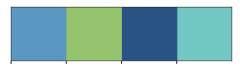

In [37]:
colors = met_brewer.met_brew(name="Hokusai3", n=4, brew_type="discrete")
sns.palplot(colors)

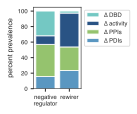

In [38]:
fig, ax = plt.subplots(figsize=(0.85, 1.5))

xs = ["negative regulator", "rewirer"]
y1 = list(df[["DN", "rewire"]].loc["pdi_change"])
y2 = list(df[["DN", "rewire"]].loc["ppi_change"])
b2 = np.add(y1, y2)
y3 = list(df[["DN", "rewire"]].loc["activ_change"])
b3 = np.add(b2, y3)
y4 = list(df[["DN", "rewire"]].loc["dbd_change"])

ax.bar(xs, y1, color=colors[0], label="∆ PDIs")
ax.bar(xs, y2, bottom=y1, color=colors[1], label="∆ PPIs")
ax.bar(xs, y3, bottom=b2, color=colors[2], label="∆ activity")
ax.bar(xs, y4, bottom=b3, color=colors[3], label="∆ DBD")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1))

ax.set_ylabel("percent prevalence")
ax.set_xticklabels(["negative\nregulator", "rewirer"])

fig.savefig("../../figures/fig7/dn_stacked_bar.pdf", dpi="figure", bbox_inches="tight")

In [39]:
# make stacked barchart situation of all assays (to compare)
tmp = pairs[pairs["dn_short"] != "NA"]
pdi_assessed = len(tmp[tmp["y1h_cat"] != "NA"])
ppi_assessed = len(tmp[tmp["y2h_cat"] != "NA"])
activ_assessed = len(tmp[tmp["m1h_cat"] != "NA"])

tot_assessed = pdi_assessed + ppi_assessed + activ_assessed

nc = pd.DataFrame.from_dict({"assessed": {"pdi": pdi_assessed/tot_assessed*100, 
                                    "ppi": ppi_assessed/tot_assessed*100,
                                    "activ": activ_assessed/tot_assessed*100}})
nc["assessed_cumsum"] = np.cumsum(nc["assessed"])
nc

,assessed,assessed_cumsum
activ,44.134078,44.134078
pdi,18.715084,62.849162
ppi,37.150838,100.000000


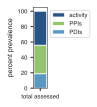

In [40]:
fig, ax = plt.subplots(figsize=(0.25, 1.5))

xs = ["assessed"]
y1 = list(nc[["assessed"]].loc["pdi"])
y2 = list(nc[["assessed"]].loc["ppi"])
b2 = np.add(y1, y2)
y3 = list(nc[["assessed"]].loc["activ"])

ax.bar(xs, y1, color=colors[0], label="PDIs")
ax.bar(xs, y2, bottom=y1, color=colors[1], label="PPIs")
ax.bar(xs, y3, bottom=b2, color=colors[2], label="activity")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1))

ax.set_ylabel("percent prevalence")
ax.set_xticklabels(["total assessed"])

fig.savefig("../../figures/fig7/dn_stacked_bar.nc.pdf", dpi="figure", bbox_inches="tight")

In [41]:
genes_w_dn = pairs[pairs["dn_short"] == "DN"][["gene_symbol", "family"]].drop_duplicates()
genes_w_rw = pairs[pairs["dn_short"] == "rewire"][["gene_symbol", "family"]].drop_duplicates()
genes_w_sim = pairs[pairs["dn_short"] == "similar"][["gene_symbol", "family"]].drop_duplicates()
tot_genes = pairs[["gene_symbol", "family"]].drop_duplicates()

tot_genes_per_f = tot_genes.groupby("family")["gene_symbol"].agg("count").reset_index()
dn_genes_per_f = genes_w_dn.groupby("family")["gene_symbol"].agg("count").reset_index()
rw_genes_per_f = genes_w_rw.groupby("family")["gene_symbol"].agg("count").reset_index()
sim_genes_per_f = genes_w_sim.groupby("family")["gene_symbol"].agg("count").reset_index()

family_cats = tot_genes_per_f.merge(dn_genes_per_f, 
                                    on="family", how="left").merge(rw_genes_per_f, 
                                                                   on="family", how="left").merge(sim_genes_per_f,
                                                                                                  on="family",
                                                                                                  how="left")
family_cats.fillna(0, inplace=True)
family_cats.columns = ["family", "tot", "dn", "rw", "sim"]

family_cats["tot_p"] = family_cats["tot"]/family_cats["tot"].sum(axis=0)*100
family_cats["dn_p"] = family_cats["dn"]/family_cats["dn"].sum(axis=0)*100
family_cats["rw_p"] = family_cats["rw"]/family_cats["rw"].sum(axis=0)*100
family_cats["sim_p"] = family_cats["sim"]/family_cats["sim"].sum(axis=0)*100
family_cats.sort_values(by="tot", ascending=False).head(11)

,family,tot,dn,rw,sim,tot_p,dn_p,rw_p,sim_p
2,C2H2 ZF,101,16.0,8.0,3.0,41.056911,22.857143,19.047619,23.076923
17,Homeodomain,23,11.0,7.0,1.0,9.349593,15.714286,16.666667,7.692308
23,Nuclear receptor,19,8.0,8.0,2.0,7.723577,11.428571,19.047619,15.384615
34,bHLH,16,5.0,4.0,1.0,6.504065,7.142857,9.523810,7.692308
11,Ets,11,1.0,1.0,0.0,4.471545,1.428571,2.380952,0.000000
35,bZIP,10,6.0,2.0,1.0,4.065041,8.571429,4.761905,7.692308
15,HMG/Sox,6,1.0,1.0,0.0,2.439024,1.428571,2.380952,0.000000
28,SMAD,6,3.0,1.0,1.0,2.439024,4.285714,2.380952,7.692308
9,E2F,4,2.0,0.0,0.0,1.626016,2.857143,0.000000,0.000000
30,T-box,4,1.0,1.0,0.0,1.626016,1.428571,2.380952,0.000000


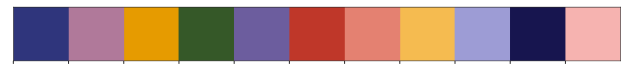

In [42]:
colors = met_brewer.met_brew(name="Renoir", n=11, brew_type="discrete")
sns.palplot(colors)

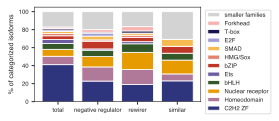

In [43]:
fig, ax = plt.subplots(figsize=(3, 1.75))

xs = ["total", "negative regulator", "rewirer", "similar"]

b = np.zeros(4)
c = 0
for i, row in family_cats.sort_values(by="tot", ascending=False).head(11).iterrows():
    y = list(row[["tot_p", "dn_p", "rw_p", "sim_p"]])
    ax.bar(xs, y, bottom=b, label=row.family, color=colors[c])
    b = np.add(b, y)
    c += 1

ax.bar(xs, np.subtract([100, 100, 100, 100], b), bottom=b, label="smaller families", color="lightgray")
ax.set_ylabel("% of categorized isoforms")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1))

fig.savefig("../../figures/fig7/dn_families_stacked_bar.pdf", dpi="figure", bbox_inches="tight")

## 5. join data with Joung et al. o/ex

In [44]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [45]:
def pd_translate(row):
    s = Seq(row["ORF sequence"])
    aa = s.translate()
    return str(aa)

joung_orf["seq_aa"] = joung_orf.apply(pd_translate, axis=1)

In [46]:
tf_id_map = {}
for tf in tfs:
    isos = tfs[tf]
    for i, iso in enumerate(isos.isoforms):
        sub_dict = {}
        try: 
            iso_clone_acc = iso.clone_acc
        except AttributeError:
            continue

        try:
            iso_seq_aa = iso.aa_seq_GENCODE
        except AttributeError:
            iso_seq_aa = iso.aa_seq
        iso_ensts = iso.ensembl_transcript_ids

        
        # first try to match based on aa seq
        joung_sub = joung_orf[joung_orf["seq_aa"] == iso_seq_aa]
        
        if len(joung_sub) > 0:
            sub_dict["match_type"] = "seq_aa"
            sub_dict["joung_id"] = joung_sub["Name"].iloc[0]
        
        # if not found, then try ensts
        if len(joung_sub) == 0:
            if iso_ensts is None:
                continue
            
            for iso_enst in iso_ensts:
                joung_sub = joung_orf[joung_orf["RefSeq and Gencode ID"].str.contains(iso_enst)]
                if len(joung_sub) > 0:
                    continue
            
            if len(joung_sub) > 0:
                sub_dict["match_type"] = "enst"
                sub_dict["joung_id"] = joung_sub["Name"].iloc[0]
            else:
                continue
        
        sub_dict["enst"] = iso_ensts
        sub_dict["seq_aa"] = iso_seq_aa
        tf_id_map[iso_clone_acc] = sub_dict

In [47]:
tf_id_map_df = pd.DataFrame.from_dict(tf_id_map, orient="index").reset_index()
print(len(tf_id_map_df))
tf_id_map_df.sample(5)

452


,index,match_type,joung_id,enst,seq_aa
363,ZNF24|2/2|01A09,seq_aa,TFORF1762,[ENST00000589881],MSAQSVEEDSILIIPTPDEEEKILRVKLEEDPDGEEGSSIPWNHLP...
261,ETV6|1/2|06A11,seq_aa,TFORF3254,[ENST00000396373],MSETPAQCSIKQERISYTPPESPVPSYASSTPLHVPVPRALRMEED...
84,ZNF662|2/5|08A08,seq_aa,TFORF2735,[ENST00000328199],MAAVALASGTRLGLVLELLPGQPALPRARRESVTFEDVAVYFSENE...
0,ZBTB18|1/2|04E08,seq_aa,TFORF2495,[ENST00000358704],MCPKGYEDSMEFPDHSRHLLQCLSEQRHQGFLCDCTVLVGDAQFRA...
90,THRB|2/2|07E08,seq_aa,TFORF3055,"[ENST00000356447, ENST00000396671, ENST0000041...",MTPNSMTENGLTAWDKPKHCPDREHDWKLVGMSEACLHRKSHSERR...


In [48]:
joung_orf = joung_orf.merge(tf_id_map_df, left_on="Name", right_on="joung_id", how="left", suffixes=("_joung",
                                                                                                     "_tf1p0"))
joung_orf.sample(5)

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Sorted M4,Sorted M5,Sorted M6,Sorted M7,seq_aa_joung,index,match_type,joung_id,enst,seq_aa_tf1p0
3002,Broad GPP,TFORF3002,NFYC,NM_014223.4,NFYC-7,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGTCCACAG...,ATGTCCACAGAAGGAGGATTTGGTGGTACTAGCAGCAGTGATGCCC...,AACATTTTGATGATTCGGTTACGC,V5,0.687279,...,1.195327,0.933637,0.827770,1.842835,MSTEGGFGGTSSSDAQQSLQSFWPRVMEEIRNLTVKDFRVQELPLA...,NFYC|1/2|12G11,seq_aa,TFORF3002,"[ENST00000372651, ENST00000372654, ENST0000044...",MSTEGGFGGTSSSDAQQSLQSFWPRVMEEIRNLTVKDFRVQELPLA...
3144,Broad GPP,TFORF3144,MIER2,NM_001346105.1,MIER2-2,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGGGCTCTG...,ATGGGCTCTGGAGACCATCAGTTCAACCTCGCAGAGATCCTGTCAC...,TCTACGTCCGGCTGCTCGTATCTA,V5,0.341402,...,0.932763,1.117080,0.188229,0.619123,MGSGDHQFNLAEILSQNYSVRGECEEASRCPDKPKEELEKDFISQS...,NaN,NaN,NaN,NaN,NaN
1481,Genewiz,TFORF1482,TP63,"NM_001114979,ENST00000418709",TP63-5,ACCGCCACCATGAATTTTGAAACTTCACGGTGTGCCACCCTACAGT...,ATGAATTTTGAAACTTCACGGTGTGCCACCCTACAGTACTGCCCTG...,TTCTTGCATAACTCTAAGGGTCGT,None,0.121237,...,2.355849,1.023599,0.031514,1.395612,MNFETSRCATLQYCPDPYIQRFVETPAHFSWKESYYRSTMSQSTQT...,NaN,NaN,NaN,NaN,NaN
1476,Genewiz,TFORF1477,VAX1,"NM_001112704,ENST00000369206",VAX1-2,ACCGCCACCATGTTCGGGAAACCAGACAAAATGGACGTTCGATGCC...,ATGTTCGGGAAACCAGACAAAATGGACGTTCGATGCCACTCGGACG...,GCTAAAGAATCCGAGCGGCAAGGT,None,0.553466,...,1.636410,2.141836,1.286925,0.972661,MFGKPDKMDVRCHSDAEAARVSKNAHKESRESKGAEGNLPAAFLKE...,NaN,NaN,NaN,NaN,NaN
2902,Genewiz,TFORF2902,DACH1,"NM_004392,ENST00000620444",DACH1-2,ACCGCCACCATGGCAGTGCCGGCGGCTTTGATCCCTCCGACCCAGC...,ATGGCAGTGCCGGCGGCTTTGATCCCTCCGACCCAGCTGGTCCCCC...,ATCTATTGTGACTAAGCCAACTTA,None,1.023501,...,0.965387,0.799429,0.649439,0.771821,MAVPAALIPPTQLVPPQPPISTSASSSGTTTSTSSATSSPAPSIGP...,NaN,NaN,NaN,NaN,NaN


In [49]:
joung_data = joung_orf.merge(joung_data, on="Name", how="left")

In [50]:
dn_ref = pairs[["gene_symbol", "family", "clone_acc_ref", "is_ref_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_ref.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_ref["dn_cat"] = "ref"
dn_ref["iso_status"] = "ref"

In [51]:
dn_alt = pairs[["gene_symbol", "family", "clone_acc_alt", "is_alt_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_alt.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_alt["is_MANE_select"] = False # assuming none of the alts are the MANE select
dn_alt["iso_status"] = "alt"

In [52]:
dn_cats = dn_ref.append(dn_alt).drop_duplicates()

In [53]:
dn_cats = dn_cats.merge(joung_data, left_on="tf1p0_id", right_on="index", how="left")

In [54]:
dn_cats.iso_status.value_counts()

alt    446
ref    246
Name: iso_status, dtype: int64

In [55]:
dn_cats[~pd.isnull(dn_cats["Name"])].iso_status.value_counts()

ref    220
alt    182
Name: iso_status, dtype: int64

In [56]:
refs_inc = len(dn_cats[(~pd.isnull(dn_cats["Name"])) & (dn_cats["iso_status"] == "ref")])
refs_tf1p0 = len(dn_cats[dn_cats["iso_status"] == "ref"])
print("%% of our ref seqs included in joung: %s" % (refs_inc/refs_tf1p0*100))

% of our ref seqs included in joung: 89.43089430894308


In [57]:
alts_inc = len(dn_cats[(~pd.isnull(dn_cats["Name"])) & (dn_cats["iso_status"] == "alt")])
alts_tf1p0 = len(dn_cats[dn_cats["iso_status"] == "alt"])
print("%% of our alt seqs included in joung: %s" % (alts_inc/alts_tf1p0*100))

% of our alt seqs included in joung: 40.80717488789238


In [58]:
dn_cats["orf_len"] = dn_cats["seq_aa_joung"].str.len()

In [59]:
joung_down_tf1p0_map = joung_down_map.merge(dn_cats[["TF ORF", "tf1p0_id", "iso_status", "dn_cat", "orf_len"]],
                                           left_on="TF", right_on="TF ORF")
print(len(joung_down_tf1p0_map))
print(len(joung_down_tf1p0_map["TF ORF"].unique()))

76492
399


In [60]:
joung_down_tf1p0_map.fillna("NA", inplace=True)

In [61]:
joung_tf1p0_cnts = joung_down_tf1p0_map.groupby(["TF", "tf1p0_id", "iso_status", 
                                                 "dn_cat", "orf_len"])["TF ORF"].agg("count").reset_index()
joung_tf1p0_cnts.columns = ["TF", "tf1p0_id", "iso_status", "dn_cat", "orf_len", "tot_cell_cnt"]

In [62]:
dn_cats_nonan = dn_cats[~pd.isnull(dn_cats["Diffusion P-value"])]
len(dn_cats_nonan)

400

In [63]:
dn_cats_nonan["neglog_diff_pval"] = -np.log10(dn_cats_nonan["Diffusion P-value"])
dn_cats_nonan.fillna("NA", inplace=True)

In [64]:
dn_cats_nonan_ref = dn_cats_nonan[dn_cats_nonan["iso_status"] == "ref"]
dn_cats_nonan_alt = dn_cats_nonan[dn_cats_nonan["iso_status"] == "alt"]
dn_cats_nonan_diff = dn_cats_nonan_ref.merge(dn_cats_nonan_alt, on=["gene_name", "family", "RefSeq Gene Name"],
                                             how="left", suffixes=("_ref", "_alt"))
dn_cats_nonan_diff["diff_pval_diff"] = dn_cats_nonan_diff["Diffusion P-value_ref"] - dn_cats_nonan_diff["Diffusion P-value_alt"]
dn_cats_nonan_diff["diff_diff_diff"] = dn_cats_nonan_diff["Diffusion difference_ref"] - dn_cats_nonan_diff["Diffusion difference_alt"]

dn_cats_nonan_diff["abs_ddd"] = np.abs(dn_cats_nonan_diff["diff_diff_diff"])

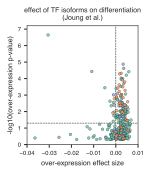

In [65]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan[dn_cats_nonan["dn_cat"].isin(["ref", "similar", "rewire", "DN"])], 
                     x="Diffusion difference", y="neglog_diff_pval", 
                     hue="dn_cat", palette=dn_pal, linewidth=0.25, edgecolor="black", alpha=0.8, zorder=10,
                     **{"s": 8})

ax.set_xlabel("over-expression effect size")
ax.set_ylabel("-log10(over-expression p-value)")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")

ax.set_xlim((-0.04, 0.01))
ax.set_ylim((-0.01, 7.2))
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=0.5)
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()

fig.savefig("../../figures/fig7/Joung_Volcano.pdf", dpi="figure", bbox_inches="tight")

In [66]:
joung_cells["Name"] = joung_cells["TF"].str.strip().str.split("-", expand=True)[0]
print(len(joung_cells))

# # filter out anything with score < 0.2
joung_cells = joung_cells[joung_cells["prediction.score.max"] > 0.2]
print(len(joung_cells))

28825
23604


In [67]:
joung_cells_grp = joung_cells.groupby(["Name", "TF", "predicted.id"])["batch"].agg("count").reset_index()

In [68]:
joung_tf1p0_cnts["cell_cnt_qcut"] = pd.qcut(joung_tf1p0_cnts["tot_cell_cnt"], q=4, labels=[1, 2, 3, 4])
dn_cats_nonan = dn_cats_nonan.merge(joung_tf1p0_cnts[["TF", "tot_cell_cnt", "cell_cnt_qcut"]], 
                                    left_on="TF ORF", right_on="TF")

In [69]:
tot_cell_cnt = dn_cats_nonan[["Name", "TF", "tot_cell_cnt"]].drop_duplicates()
diff_cell_cnt = joung_cells.groupby(["Name", "TF"])["batch"].agg("count").reset_index()
cell_cnt = tot_cell_cnt.merge(diff_cell_cnt, on=["Name", "TF"], how="left")
cell_cnt.fillna(0, inplace=True)
cell_cnt.columns = ["Name", "TF", "tot_cell_cnt", "diff_cell_cnt"]

orf_enr = cell_cnt.merge(joung_cells_grp, on=["Name", "TF"], how="left")
orf_enr["batch"].fillna(0, inplace=True)

orf_enr.columns = ["Name", "TF", "tot_cell_cnt", "diff_cell_cnt", "predicted.id", "id_cell_cnt"]
orf_enr["perc_cells_of_diff_tf"] = orf_enr["id_cell_cnt"]/orf_enr["diff_cell_cnt"]
orf_enr["perc_cells_of_tot_tf"] = orf_enr["id_cell_cnt"]/orf_enr["tot_cell_cnt"]

In [70]:
orf_enr_dn = orf_enr.merge(dn_cats_nonan[["gene_name", "Name", "tf1p0_id",
                                          "dn_cat"]], on="Name").drop_duplicates(subset=["tf1p0_id",
                                                                                         "predicted.id",
                                                                                         "dn_cat"])

In [71]:
has_alt = list(orf_enr_dn[orf_enr_dn["dn_cat"] != "ref"]["gene_name"].unique())
orf_enr_dn_filt = orf_enr_dn[orf_enr_dn["gene_name"].isin(has_alt)]

has_ref = list(orf_enr_dn_filt[orf_enr_dn_filt["dn_cat"] == "ref"]["gene_name"].unique())
orf_enr_dn_filt = orf_enr_dn_filt[orf_enr_dn_filt["gene_name"].isin(has_ref)]
len(orf_enr_dn_filt)

1048

In [72]:
orf_enr_dn_filt["dn_cat_s"] = pd.Categorical(orf_enr_dn_filt["dn_cat"], ["ref", "similar", "rewire", 
                                                                         "DN", "NA", "likely"])
orf_enr_dn_filt = orf_enr_dn_filt.sort_values(by=["gene_name", "dn_cat_s"])
orf_enr_dn_filt[orf_enr_dn_filt["gene_name"] == "PBX1"]

,Name,TF,tot_cell_cnt,diff_cell_cnt,predicted.id,id_cell_cnt,perc_cells_of_diff_tf,perc_cells_of_tot_tf,gene_name,tf1p0_id,dn_cat,dn_cat_s
32,TFORF0427,TFORF0427-PBX1,285,7.0,Ciliated epithelial cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
33,TFORF0427,TFORF0427-PBX1,285,7.0,Intestinal epithelial cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
34,TFORF0427,TFORF0427-PBX1,285,7.0,Metanephric cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
35,TFORF0427,TFORF0427-PBX1,285,7.0,STC2_TLX1 positive cells,1.0,0.142857,0.003509,PBX1,PBX1|1/2|02A05,ref,ref
36,TFORF0427,TFORF0427-PBX1,285,7.0,Squamous epithelial cells,3.0,0.428571,0.010526,PBX1,PBX1|1/2|02A05,ref,ref
571,TFORF0429,TFORF0429-PBX1,1000,27.0,Bronchiolar and alveolar epithelial cells,1.0,0.037037,0.001000,PBX1,PBX1|2/2|02C05,DN,DN
572,TFORF0429,TFORF0429-PBX1,1000,27.0,Ciliated epithelial cells,1.0,0.037037,0.001000,PBX1,PBX1|2/2|02C05,DN,DN
573,TFORF0429,TFORF0429-PBX1,1000,27.0,Erythroblasts,5.0,0.185185,0.005000,PBX1,PBX1|2/2|02C05,DN,DN
574,TFORF0429,TFORF0429-PBX1,1000,27.0,Inhibitory neurons,1.0,0.037037,0.001000,PBX1,PBX1|2/2|02C05,DN,DN
575,TFORF0429,TFORF0429-PBX1,1000,27.0,Intestinal epithelial cells,2.0,0.074074,0.002000,PBX1,PBX1|2/2|02C05,DN,DN


In [73]:
cell_cnt["undiff_cell_cnt"] = cell_cnt["tot_cell_cnt"] - cell_cnt["diff_cell_cnt"]
len(cell_cnt)

399

In [74]:
cell_cnt["diff_cell_perc"] = (cell_cnt["diff_cell_cnt"]/cell_cnt["tot_cell_cnt"])*100
cell_cnt["undiff_cell_perc"] = (cell_cnt["undiff_cell_cnt"]/cell_cnt["tot_cell_cnt"])*100
cell_cnt[cell_cnt["TF"].str.contains("GRHL3")]

,Name,TF,tot_cell_cnt,diff_cell_cnt,undiff_cell_cnt,diff_cell_perc,undiff_cell_perc
4,TFORF2165,TFORF2165-GRHL3,111,36.0,75.0,32.432432,67.567568
222,TFORF2166,TFORF2166-GRHL3,47,0.0,47.0,0.000000,100.000000
223,TFORF2167,TFORF2167-GRHL3,500,12.0,488.0,2.400000,97.600000
224,TFORF2168,TFORF2168-GRHL3,152,40.0,112.0,26.315789,73.684211


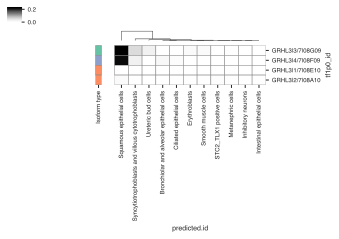

In [75]:
tmp = orf_enr_dn_filt[orf_enr_dn_filt["tf1p0_id"].str.contains("GRHL3")].pivot(index="tf1p0_id", 
                                                                               columns="predicted.id", 
                                                                               values="perc_cells_of_tot_tf")
tmp.drop(np.nan, axis=1, inplace=True)
tmp = tmp.loc[["GRHL3|3/7|08G09", "GRHL3|4/7|08F09", "GRHL3|1/7|08E10", "GRHL3|2/7|08A10"]]
tmp.fillna(0, inplace=True)

idx = pd.DataFrame(tmp.index)
idx = idx.merge(orf_enr_dn_filt[["tf1p0_id", "dn_cat"]], on="tf1p0_id").drop_duplicates().set_index("tf1p0_id")
idx["Isoform type"] = idx.dn_cat.map(dn_pal)

g = sns.clustermap(tmp, cmap="Greys", row_cluster=False, row_colors=idx["Isoform type"],
                   figsize=(4, 1), yticklabels=True, cbar_pos=(0, 1, 0.05, 0.2), linewidth=0.5, linecolor="grey")

g.savefig("../../figures/fig7/Joung_GRHL3_hm.pdf", bbox_inches="tight", dpi="figure")

## 6. plot expression profiles of isoform categories

In [76]:
# use same downsample as prev figs
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

In [77]:
# calculate expression ratios - dev
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [78]:
# calculate expression ratios - gtex
per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [79]:
# calculate expression ratios -gtex downsampled
per_gene_gtex_ds = ((2 ** df_gtex.loc[:,metadata_gtex_dummy.index] - 1)
                   .groupby(genes_gtex)
                   .transform('sum'))

f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

In [80]:
# calculate gene-level tissue specificities
gene_dev_nonan_taus, gene_dev_nan_taus, gene_dev_array_max = calculate_tau(per_gene_dev.drop_duplicates())
gene_gtex_nonan_taus, gene_gtex_nan_taus, gene_gtex_array_max = calculate_tau(per_gene_gtex.drop_duplicates())
gene_gtex_ds_nonan_taus, gene_gtex_ds_nan_taus, gene_gtex_ds_array_max = calculate_tau(per_gene_gtex_ds.drop_duplicates())

In [81]:
gene_taus = pd.DataFrame()
gene_taus["UID"] = per_gene_dev.drop_duplicates().index
gene_taus["dev_tau"] = gene_dev_nan_taus
gene_taus["gtex_tau"] = gene_gtex_nan_taus
gene_taus["gtex_ds_tau"] = gene_gtex_ds_nan_taus
gene_taus["gene_name"] = gene_taus["UID"].str.split("|", expand=True)[0]
gene_taus.sample(5)

,UID,dev_tau,gtex_tau,gtex_ds_tau,gene_name
182,TFAP2A|1/4|09D09 nomatch,0.971828,0.982358,0.942571,TFAP2A
277,ZNF559|1/3|12E03 ZNF559-202_ZNF559-213,0.675596,0.810397,0.749492,ZNF559
161,SOX5|1/2|08D03 SOX5-220,0.968608,0.973912,0.960261,SOX5
153,SIX1|1/2|11C07 SIX1-201_SIX1-206,0.945127,0.994915,0.983967,SIX1
65,HNF4A|1/6|10D08 HNF4A-201,0.911653,0.939230,0.961882,HNF4A


In [82]:
# join w pairs table
dev_ratios = f_dev.reset_index()
dev_ratios["clone_acc"] = dev_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
dev_ratios = dev_ratios[dev_ratios["clone_acc"] != "noclone"]
len(dev_ratios)

756

In [83]:
gtex_ratios = f_gtex.reset_index()
gtex_ratios["clone_acc"] = gtex_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
gtex_ratios = gtex_ratios[gtex_ratios["clone_acc"] != "noclone"]
len(gtex_ratios)

756

In [84]:
gtex_ds_ratios = f_gtex_downsample.reset_index()
gtex_ds_ratios["clone_acc"] = gtex_ds_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
gtex_ds_ratios = gtex_ds_ratios[gtex_ds_ratios["clone_acc"] != "noclone"]
len(gtex_ds_ratios)

756

In [85]:
dev_ratios = dev_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
gtex_ratios = gtex_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
gtex_ds_ratios = gtex_ds_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
print(len(dev_ratios))
print(len(gtex_ratios))
print(len(gtex_ds_ratios))

692
692
692


In [86]:
dn_cats = dn_cats.merge(gene_taus, on="gene_name")
print(len(dn_cats))
dn_cats.head()

692


,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len,UID,dev_tau,gtex_tau,gtex_ds_tau
0,ZBTB18,C2H2 ZF,ZBTB18|1/2|04E08,False,True,ref,ref,Genewiz,TFORF2495,ZBTB18,...,TFORF2495-ZBTB18,0.172521,0.002115,0.168074,-0.004946,531.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.950431
1,ZBTB18,C2H2 ZF,ZBTB18|2/2|12E05,False,False,rewire,alt,Genewiz,TFORF2494,ZBTB18,...,TFORF2494-ZBTB18,0.006114,0.003615,0.244046,-0.003313,522.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.950431
2,PRRX1,Homeodomain,PRRX1|2/3|09F06,False,True,ref,ref,Genewiz,TFORF1217,PRRX1,...,TFORF1217-PRRX1,0.365286,0.000400,0.000021,-0.009730,245.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.847919
3,PRRX1,Homeodomain,PRRX1|1/3|09C07,False,False,NA,alt,Genewiz,TFORF1218,PRRX1,...,TFORF1218-PRRX1,0.006905,0.002594,0.000440,-0.001672,217.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.847919
4,PRRX1,Homeodomain,PRRX1|3/3|09H08,False,False,rewire,alt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.847919


In [87]:
ref_expr = dn_cats.groupby(["gene_name", "family", "dn_cat", "dev_tau",
                            "gtex_tau", "gtex_ds_tau"])["tf1p0_id"].agg("count").reset_index()
ref_expr = ref_expr.pivot(index="gene_name",
                          columns="dn_cat", values="tf1p0_id")
ref_expr.fillna(0, inplace=True)

In [88]:
def categorize_gene(row):
    if row.DN > 0 and row.rewire == 0 and row.similar == 0:
        return "DN"
    elif row.rewire > 0 and row.DN == 0 and row.similar == 0:
        return "rewire"
    elif row.similar > 0 and row.DN == 0 and row.rewire == 0:
        return "similar"
    elif row.NA > 0:
        return "NA"
    else:
        return "combination"
    
ref_expr["gene_cat"] = ref_expr.apply(categorize_gene, axis=1)
ref_expr.reset_index(inplace=True)
ref_expr = ref_expr.merge(dn_cats[["gene_name", "family", "dev_tau", "gtex_tau", "gtex_ds_tau"]],
                          on="gene_name").drop_duplicates()
print(len(ref_expr))
ref_expr.sample(5)

246


,gene_name,DN,NA,likely,ref,rewire,similar,gene_cat,family,dev_tau,gtex_tau,gtex_ds_tau
562,ZNF277,0.0,1.0,0.0,1.0,0.0,0.0,NA,C2H2 ZF; BED ZF,0.801800,0.823503,0.758730
490,ZIC3,0.0,0.0,0.0,1.0,2.0,0.0,rewire,C2H2 ZF,0.950241,0.978782,0.969147
331,RELA,1.0,0.0,0.0,1.0,0.0,0.0,DN,Rel,0.739859,0.751909,0.692365
158,HOXA1,1.0,0.0,0.0,1.0,0.0,0.0,DN,Homeodomain,0.927557,0.975478,0.968271
254,NFYA,0.0,0.0,0.0,1.0,2.0,0.0,rewire,CBF/NF-Y,0.809285,0.840831,0.837620


0.011197407173103874
0.05613202972362681
1.0
0.9697827848906592


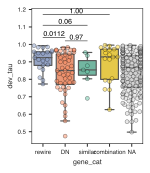

In [89]:
nice_boxplot(ref_expr, "dev_tau", "gene_cat", dn_pal, ["rewire", "DN", "similar", "combination", "NA"], 
            [1.04, 1.11, 1.17, 1.02], 0.35, "", ["rewirer", "negative regulator", "similar", "combination", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.3, 1.23), 
            "developmental gene expression\nclassified TF genes", 
            "../../figures/fig7/DN_DevTau_Gene_Boxplot.pdf")